#Предсказание рейтинга качества шоколада по его характеристикам

Никнейм на Kaggle: Evgeny_Dolgov

#Импорт библиотек, константы, загрузка данных

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"

In [ ]:
data = pd.read_csv(TRAIN)

Удалим малое количество пропусков

In [ ]:
data.dropna(axis=0, inplace=True)

Распределим данные на целевую и остальные

In [ ]:
X = data.drop('Rating', axis=1)
y = data['Rating']

#Обзор данных, промежуточный вывод

In [ ]:
X.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,Criollo,Indonesia


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1253 entries, 0 to 1254
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Company               1253 non-null   object
 1   Specific Bean Origin  1253 non-null   object
 2   REF                   1253 non-null   int64 
 3   Review                1253 non-null   int64 
 4   Cocoa Percent         1253 non-null   object
 5   Company Location      1253 non-null   object
 6   Bean Type             1253 non-null   object
 7   Broad Bean Origin     1253 non-null   object
dtypes: int64(2), object(6)
memory usage: 88.1+ KB


Первое что мы сделаем, это переведем признак 'Cocoa Percent' в числовой тип, так будет проще для будущей модели.

In [ ]:
X["Cocoa Percent"] = X["Cocoa Percent"].str.rstrip("%").astype(float) / 100

In [ ]:
for c in X.columns:
    if X[c].dtype == 'object':
          print(c, len(X[c].unique()))

Company 376
Specific Bean Origin 761
Company Location 58
Bean Type 38
Broad Bean Origin 83


Также мы видим, что уникальных значений в 'Specific Bean Origin' слишком много, взглянем на них поподробнее

In [ ]:
X[['Specific Bean Origin']].head(12)

,Specific Bean Origin
0,Rio Caribe
1,"Ocumare, Premier Cru, Quizas No. 2"
2,Tanzania
3,Cooproagro
4,"Java, Indonesie"
5,Chuno
6,Beniamo
7,Cuyagua
8,"Lam Dong, Batch 153"
9,Star of Ecuador


Из этого можно сделать вывод, что после запятой идёт уточнение, из-за этого и появилось много уникальных значений. Оставим только слово до запятой, остальное удалим, смысл признака от этого сильно не потеряется

In [ ]:
X['Specific Bean Origin'] = X['Specific Bean Origin'].str.split(',').str[0]

In [ ]:
print(c, len(X['Specific Bean Origin'].unique()))

Broad Bean Origin 529


Уже лучше!

Ещё мы видим, что в 'Bean Type' очень много пропусков, эти пропуски обозначены неразрывным пробелом, оставим как есть, тк удаление этого признака неминуемо ведёт к потере R2

Посмотрим на корреляцию признаков(и числовых, и категориальных)

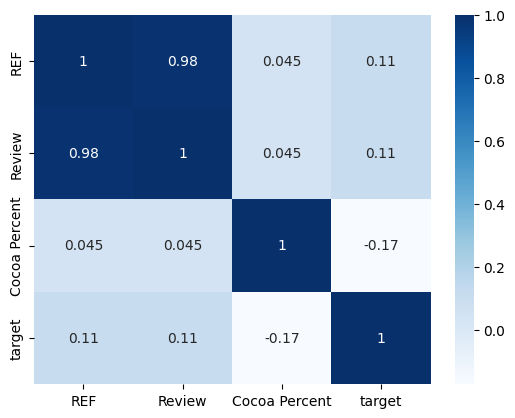

In [ ]:
import seaborn as sb

X['target'] = y

cols = X.columns[X.dtypes != 'object']

corr = X[cols].corr()
sb.heatmap(corr, cmap="Blues", annot=True)

X.drop('target', axis=1, inplace=True)

'REF' и 'Review' сильно коррелируют между собой, один из признаков придется удалить. Удалим 'Review' как менее информативный

In [ ]:
X.drop('Review', axis=1, inplace=True)

In [ ]:
!pip install association-metrics

In [ ]:
import association_metrics as am

XC = X.apply(
        lambda x: x.astype("category") if x.dtype == "object" else x)

cramersv = am.CramersV(XC)

cramersv.fit()

,Company,Specific Bean Origin,Company Location,Bean Type,Broad Bean Origin
Company,1.000000,0.653217,0.999651,0.616975,0.607303
Specific Bean Origin,0.653217,1.000000,0.735872,0.737475,0.969210
Company Location,0.999651,0.735872,1.000000,0.291667,0.383039
Bean Type,0.616975,0.737475,0.291667,1.000000,0.388294
Broad Bean Origin,0.607303,0.969210,0.383039,0.388294,1.000000


Видим сразу 2 пары коррелирующих между собой признаков, это 'Company' с 'Company Location' и 'Specific Bean Origin' с 'Broad Bean Origin'. С первой парой мы разберемся позже, тк удаление одного из них сильно роняет r2_score, а вот со второй мы можем поработать - удалить менее информативный признак, сделаем это!

In [ ]:
X.drop('Broad Bean Origin', axis=1, inplace=True)

#Построение новых признаков, обоснование

Теперь работаем с первой парой, создадим новый признак из старого. Действуем следующим образом => заменяем страну на материк, на которой он находится(судя по эскпериментам, r2_score становится немного выше после такого преобразования, да и чем меньше уникальных значений, тем лучше для модели понимать что происходит)

In [ ]:
# Создайте словарь с маппингом стран на континенты
country_to_continent = {
    'U.K.': 'Europe',
    'Switzerland': 'Europe',
    'U.S.A.': 'North America',
    'France': 'Europe',
    'Ecuador': 'South America',
    'Colombia': 'South America',
    'Canada': 'North America',
    'Belgium': 'Europe',
    'Spain': 'Europe',
    'Italy': 'Europe',
    'New Zealand': 'Oceania',
    'Venezuela': 'South America',
    'Austria': 'Europe',
    'Japan': 'Asia',
    'Vietnam': 'Asia',
    'Sweden': 'Europe',
    'Madagascar': 'Africa',
    'Brazil': 'South America',
    'Peru': 'South America',
    'Honduras': 'South America',
    'Fiji': 'Oceania',
    'Australia': 'Oceania',
    'Eucador': 'South America',
    'Ireland': 'Europe',
    'Poland': 'Europe',
    'Hungary': 'Europe',
    'Germany': 'Europe',
    'South Korea': 'Asia',
    'Israel': 'Asia',
    'Guatemala': 'South America',
    'Domincan Republic': 'North America',
    'Denmark': 'Europe',
    'Grenada': 'North America',
    'Lithuania': 'Europe',
    'Scotland': 'Europe',
    'Argentina': 'South America',
    'Finland': 'Europe',
    'Singapore': 'Asia',
    'South Africa': 'Africa',
    'Ghana': 'Africa',
    'Chile': 'South America',
    'Puerto Rico': 'North America',
    'India': 'Asia',
    'Costa Rica': 'North America',
    'Sao Tome': 'Africa',
    'St. Lucia': 'North America',
    'Nicaragua': 'South America',
    'Mexico': 'North America',
    'Bolivia': 'South America',
    'Niacragua': 'South America',
    'Iceland': 'Europe',
    'Amsterdam': 'Europe',
    'Wales': 'Europe',
    'Netherlands': 'Europe',
    'Russia': 'Asia',
    'Portugal': 'Europe',
    'Suriname': 'South America',
    'Czech Republic': 'Europe'
}


X['Company Location'] = X['Company Location'].map(country_to_continent)


In [ ]:
unique_values = X['Company Location'].unique()
print(unique_values)

['Europe' 'North America' 'South America' 'Oceania' 'Asia' 'Africa']


#Изучение выбросов и распределения данных

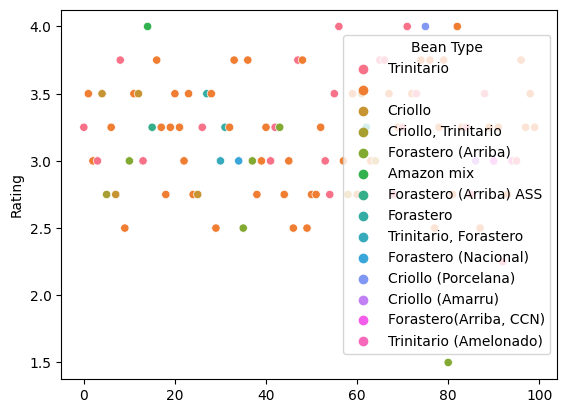

In [ ]:
import seaborn as sns

sns.scatterplot(data=X.iloc[:100], x=X.iloc[:100].index, y=y[:100], hue='Bean Type');

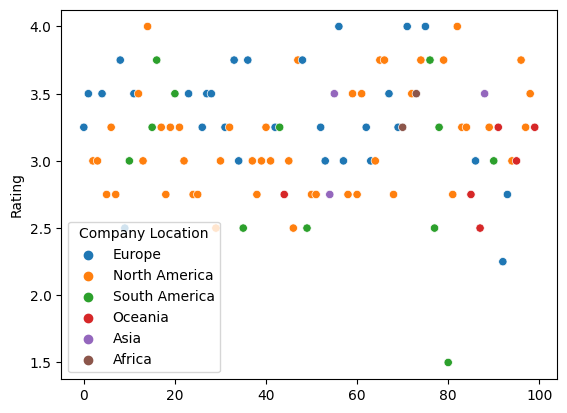

In [ ]:
import seaborn as sns

sns.scatterplot(data=X.iloc[:100], x=X.iloc[:100].index, y=y[:100], hue='Company Location');

Данные распределены хаотично, нет какой-либо зависимости

Взглянем на паспределение целевой переменной

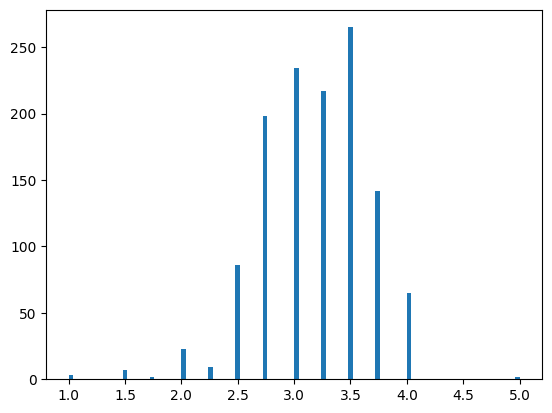

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y, bins=100);

Оно в полном порядке :)

Убедимся, нет ли у нас выбросов и аномальных значений

In [ ]:
cat_cols = X.columns[X.dtypes == 'object']
num_cols = X.columns[X.dtypes != 'object']

REF


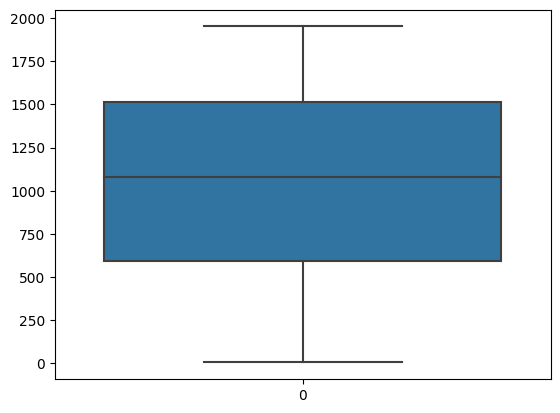

Cocoa Percent


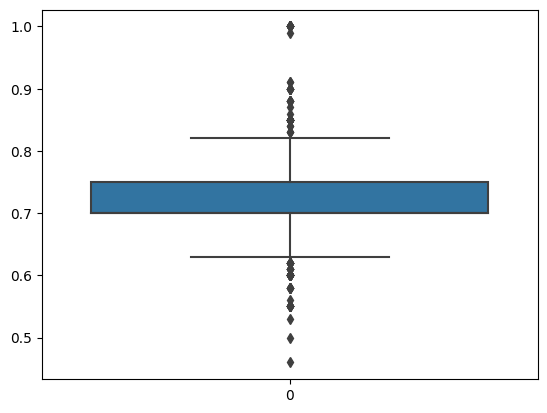

In [ ]:
for col in num_cols:
    print(col)
    sb.boxplot(X[col])
    plt.show()

Черные точки в Cocoa Percent это не выбросы, такое количество какао в шоколаде и вправду может быть.

#Построение модели

Используем CatBoostRegressor и пусть он сам будет кодировать категориальные признаки

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1253 entries, 0 to 1254
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1253 non-null   object 
 1   Specific Bean Origin  1253 non-null   object 
 2   REF                   1253 non-null   int64  
 3   Cocoa Percent         1253 non-null   float64
 4   Company Location      1253 non-null   object 
 5   Bean Type             1253 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 100.8+ KB


In [ ]:
cat_features=[0,1,4,5]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
!pip install catboost -q

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import *
model = CatBoostRegressor(cat_features=cat_features)
model.fit(X_train, y_train)
pred= model.predict(X_test)

r2_score((y_test), (pred))

Learning rate set to 0.040538
0:	learn: 0.4637839	total: 5.34ms	remaining: 5.34s
1:	learn: 0.4616769	total: 8.45ms	remaining: 4.21s
2:	learn: 0.4597738	total: 11.7ms	remaining: 3.9s
3:	learn: 0.4580704	total: 13.5ms	remaining: 3.36s
4:	learn: 0.4563614	total: 15.4ms	remaining: 3.06s
5:	learn: 0.4557998	total: 16.3ms	remaining: 2.7s
6:	learn: 0.4539345	total: 19.6ms	remaining: 2.77s
7:	learn: 0.4521658	total: 22.7ms	remaining: 2.81s
8:	learn: 0.4510918	total: 26.1ms	remaining: 2.87s
9:	learn: 0.4499041	total: 27.9ms	remaining: 2.76s
10:	learn: 0.4488118	total: 29ms	remaining: 2.61s
11:	learn: 0.4474686	total: 32.1ms	remaining: 2.64s
12:	learn: 0.4463503	total: 34.5ms	remaining: 2.62s
13:	learn: 0.4452456	total: 36ms	remaining: 2.53s
14:	learn: 0.4438637	total: 39ms	remaining: 2.56s
15:	learn: 0.4423607	total: 42.2ms	remaining: 2.6s
16:	learn: 0.4410598	total: 45.3ms	remaining: 2.62s
17:	learn: 0.4400211	total: 48ms	remaining: 2.62s
18:	learn: 0.4387454	total: 53.8ms	remaining: 2.78s
19:

0.26848028996987594

Такая конфигурация дала мой наибольший r2_score на kaggle, возможно я мало пытался, но получилось вот так. При подборах гиперпараметров R2 рос со знаком минус, поэтому оставил только этот вариант

In [ ]:
model = CatBoostRegressor(cat_features=cat_features)
model.fit(X, y)

Learning rate set to 0.042428
0:	learn: 0.4761451	total: 9.82ms	remaining: 9.81s
1:	learn: 0.4732798	total: 22.8ms	remaining: 11.4s
2:	learn: 0.4709530	total: 37.7ms	remaining: 12.5s
3:	learn: 0.4692508	total: 59.5ms	remaining: 14.8s
4:	learn: 0.4674055	total: 66.6ms	remaining: 13.3s
5:	learn: 0.4659155	total: 81.5ms	remaining: 13.5s
6:	learn: 0.4637925	total: 98.6ms	remaining: 14s
7:	learn: 0.4619142	total: 113ms	remaining: 14.1s
8:	learn: 0.4594929	total: 123ms	remaining: 13.5s
9:	learn: 0.4578626	total: 134ms	remaining: 13.2s
10:	learn: 0.4556510	total: 145ms	remaining: 13s
11:	learn: 0.4543333	total: 158ms	remaining: 13s
12:	learn: 0.4530903	total: 164ms	remaining: 12.4s
13:	learn: 0.4517209	total: 180ms	remaining: 12.6s
14:	learn: 0.4502031	total: 186ms	remaining: 12.2s
15:	learn: 0.4484830	total: 209ms	remaining: 12.8s
16:	learn: 0.4472537	total: 223ms	remaining: 12.9s
17:	learn: 0.4455126	total: 234ms	remaining: 12.7s
18:	learn: 0.4439132	total: 246ms	remaining: 12.7s
19:	learn:

#Вывод: Мы достигли r2_score=0.2 при помощи обработки признаков, построения новых признаков и обработки пропусков. Без этих действий модель имела бы очень плохую предсказывательную способность

#Предсказание!

In [ ]:
test_data = pd.read_csv(TEST)

Делаем те же действия, что и с датасетом для трейна

In [ ]:
unique_values = test_data['Company Location'].unique()
print(unique_values)

['U.S.A.' 'Spain' 'Colombia' 'Hungary' 'Germany' 'Israel' 'U.K.' 'France'
 'Denmark' 'Peru' 'Italy' 'Switzerland' 'Canada' 'Belgium' 'Australia'
 'Ireland' 'Vietnam' 'Japan' 'Lithuania' 'Ecuador' 'Amsterdam' 'Guatemala'
 'Brazil' 'Martinique' 'Singapore' 'Nicaragua' 'Venezuela' 'Argentina'
 'Costa Rica' 'New Zealand' 'Austria' 'South Korea' 'Madagascar'
 'Philippines' 'Puerto Rico' 'Scotland' 'Mexico' 'Iceland' 'Fiji' 'Poland'
 'Sao Tome' 'Netherlands']


In [ ]:
country_to_continent = {
    'U.S.A.': 'North America',
    'Spain': 'Europe',
    'Colombia': 'South America',
    'Hungary': 'Europe',
    'Germany': 'Europe',
    'Israel': 'Asia',
    'U.K.': 'Europe',
    'France': 'Europe',
    'Denmark': 'Europe',
    'Peru': 'South America',
    'Italy': 'Europe',
    'Switzerland': 'Europe',
    'Canada': 'North America',
    'Belgium': 'Europe',
    'Australia': 'Oceania',
    'Ireland': 'Europe',
    'Vietnam': 'Asia',
    'Japan': 'Asia',
    'Lithuania': 'Europe',
    'Ecuador': 'South America',
    'Amsterdam': 'Europe',
    'Guatemala': 'South America',
    'Brazil': 'South America',
    'Martinique': 'North America',
    'Singapore': 'Asia',
    'Nicaragua': 'South America',
    'Venezuela': 'South America',
    'Argentina': 'South America',
    'Costa Rica': 'North America',
    'New Zealand': 'Oceania',
    'Austria': 'Europe',
    'South Korea': 'Asia',
    'Madagascar': 'Africa',
    'Philippines': 'Asia',
    'Puerto Rico': 'North America',
    'Scotland': 'Europe',
    'Mexico': 'North America',
    'Iceland': 'Europe',
    'Fiji': 'Oceania',
    'Poland': 'Europe',
    'Sao Tome': 'Africa',
    'Netherlands': 'Europe'
}



In [ ]:
test_data.dropna(axis=0, inplace=True)
test_data["Cocoa Percent"] = test_data["Cocoa Percent"].str.rstrip("%").astype(float) / 100
test_data['Specific Bean Origin'] = test_data['Specific Bean Origin'].str.split(',').str[0]

test_data.drop('Review', axis=1, inplace=True)
test_data['Company Location'] = test_data['Company Location'].map(country_to_continent)
test_data.drop('Broad Bean Origin', axis=1, inplace=True)

In [ ]:
pred=model.predict(test_data)

In [ ]:
test_data['id'] = np.arange(len(test_data))
test_data['Rating'] = pred

test_data[['id','Rating']].to_csv("baseline_submission.csv", index=False)